# Full analysis of the Weibo dataset 

This notebook shows how to reproduce the analaysis of a bursty system as performed in [1]. The Weibo dataset is taken as example. The original data, originally collected in [2], can be found at [3].


The analysis is divided in three sections:
1. In the first section, time series are created by parsing the data. For each Weibo post in the data, we collect  the text of the post as well as its timestamp. If the text contains one or more hashtags, the timestamp is added to the time series of these hashtags. Finally, each series of event times is converted in a series of interevent times and is saved on a file.

2. In the second section we study avalanches from time series. First, we perform the percolation analysis to determine the temporal resolution. Second, we use this temporal resolution to compute avalanches probability distributions and exponents estimators. 

3. In the third section we fit the time series to the Random Field Ising Model and to the Branchig Process, determining the best parameter of each model as well as the best fit.


[1] https://arxiv.org/abs/2109.00116

[2] Assessing Censorship on Microblogs in China: Discriminatory Keyword Analysis and the Real-Name Registration Policy, K.-w. Fu, C.-h. Chan, M. Chau, IEEE Internet Computing 17, 42 (2013).

[3] Fu, KW. (2017). Weiboscope Open Data. (Dataset) The University of Hong Kong, Pokfulam, Hong Kong SAR. https://hub.hku.hk/cris/dataset/dataset107483, Fu, King Wa (2017): Weiboscope Open Data. HKU Data Repository. Dataset. https://doi.org/10.25442/hku.16674565.v1 

### Generic libraries

In [1]:
import subprocess
import numpy as np

from scipy import stats
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.ticker as tkr
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titley'] = 1.01
plt.rcParams['axes.labelsize'] = 35

plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.shadow'] = False
plt.rcParams['legend.framealpha'] = 0.0
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.handletextpad'] = 0.5

plt.rcParams['xtick.major.size'] = 9
plt.rcParams['ytick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.minor.size'] = 0

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1: Extraction of time series

### Libraries for section 1

In [2]:
import csv
# import ast
import requests


from io import BytesIO
from zipfile import ZipFile
from io import TextIOWrapper
from bs4 import BeautifulSoup

### Functions for section 1

In [3]:
# Extract the csv file contained in the zip file downloadable from `file_link`
def extract_csv(file_link, file_name):

    url = requests.get(file_link)
    ZF = ZipFile(BytesIO(url.content))
    zip_data = ZF.open(file_name[:-3] + 'csv')
    reader = csv.reader(TextIOWrapper(zip_data, encoding='utf-8',  errors='replace'))

    return reader


# An hashtag in Weibo is enclosed between two '#', i.e., #This# is an hashtag but #This is not.
def extract_hashtags(text):
    
    H = []
    indices = [i for i, x in enumerate(text) if x == '#']
    
    num, i =len(indices), 0
    while i < num-1:
        
        candidate = text[indices[i]+1:indices[i+1]]
        if ' ' not in candidate:
            H.append(candidate)
            
        i += 1
    
    return H


def from_date_to_timestamp(date):
    return int(datetime.timestamp(datetime.strptime(date, '%Y-%m-%d %H:%M:%S')))

def from_timestamp_to_date(event_time):
    return datetime.utcfromtimestamp(event_time).strftime('%b %d %H:%M:%S %z %Y')
    

### Main

In [4]:
### html request and parsing

url = 'https://hub.hku.hk/cris/dataset/dataset107483'

r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
script = soup.find_all('script')
content = str(script[1].contents[0])[28:-5]

In [5]:
true = 1
D = eval(content)

In [6]:
### Extracting links to datafiles from the html 

F = {}
path = 'https://hub.hku.hk/dataset/file/'

for k in D['dataset']['data']['datasetfile']:
    file_name = k['file']['name']
    file_link = k['file']['path']
    if 'week' in file_name:
        F[file_name] = path + file_link
    else:
        print(file_name)

README.txt
randomusers.csv
userdataREADME.txt
userdata.zip


In [7]:
### Exctracting time series from Weibo posts


start = datetime.now()


TS = {}

end_date = 0                 # Begin of temporal window
start_date = 1e30            # End of temporal window

tot_lines = 0
for file_name in F:
    
    print(file_name)
    reader = extract_csv(F[file_name], file_name)
    
    next(reader)             # First line does not contain data
    for row in reader:

        tot_lines += 1                
        text = row[6]
        date = row[8]
        
        event_time = from_date_to_timestamp(date)


        if event_time > end_date:
            end_date = event_time
        if event_time < start_date:
            start_date = event_time

        if '#' in text:

            hashtags = extract_hashtags(text)

            for h in hashtags:
                if h.strip():
                    if h not in TS:
                        TS[h] = []
                    TS[h].append(event_time)
    
    
end = datetime.now()
print('Time required:', end-start)

week1.zip
week2.zip
week10.zip
week11.zip
week12.zip
week13.zip
week14.zip
week15.zip
week16.zip
week17.zip
week18.zip
week19.zip
week20.zip
week21.zip
week22.zip
week23.zip
week24.zip
week25.zip
week26.zip
week27.zip
week28.zip
week29.zip
week30.zip
week31.zip
week32.zip
week33.zip
week34.zip
week35.zip
week36.zip
week37.zip
week38.zip
week39.zip
week3.zip
week40.zip
week41.zip
week42.zip
week43.zip
week44.zip
week45.zip
week46.zip
week47.zip
week48.zip
week49.zip
week4.zip
week50.zip
week51.zip
week52.zip
week5.zip
week6.zip
week7.zip
week8.zip
week9.zip
Time required: 15:11:59.330299


In [8]:
tot_events = 0
for k in TS:
    tot_events += len(TS[k])

print('Total number of weibo posts:', tot_lines)
print('Total number of hashtags:', len(TS))
print('Total number of events:', tot_events)
print('Data start at:', from_timestamp_to_date(start_date))
print('Data end at:', from_timestamp_to_date(end_date))

Total number of weibo posts: 226841249
Total number of hashtags: 1958768
Total number of events: 19560710
Data start at: Jan 02 05:00:00  2012
Data end at: Dec 31 04:59:59  2012


In [9]:
# Event times to interevent

for h in TS:
    TS[h] = sorted(TS[h])
    last_appearence = TS[h][-1]
    TS[h].append(end_date - last_appearence)
    for i in reversed(range(1,len(TS[h]) - 1)):
        TS[h][i] -= TS[h][i-1]
    TS[h][0] -= start_date

In [10]:
### Save hashtags and time series

dataset = 'wei'

path = './'
fhash = dataset + '_hashtags.txt'
fdata = dataset + '_ts.txt'

Fh = open(path+fhash, 'w', encoding='utf-8')
Fd = open(path+fdata, 'w')

for h in TS:

    Fh.write(str(h) + '\n')

    Fd.write(str(len(TS[h])) + ' ')
    for t in TS[h]:
        Fd.write(str(t) + ' ')
    Fd.write('\n')
    
Fh.close()
Fd.close()


### Read back

# TS = {}

# H = []
# with open(fhash, 'r') as F:
#     for line in F:
#         H.append(line.split()[0])

# with open(fdata, 'r') as F:
#     for i, line in enumerate(F):
#         l = line.split()
#         ts = [float(val) for val in l[1:]]
#         TS[H[i]] = ts


# 2: Percolation analysis 

The percolation analysis is performed by a separate code which can be found in the folder `percolation`. The folder contains the code, its associated README, a makefile to create the executable and a folder, `res`, where the results of the analysis are stored. Details regarding how to use the code are given in the README file.

The statistical analysis of avalanches is performed by a separate code which can be found in the folder `avalanches`. The folder contains the code, its associated README and a folder, `res`, where the results of the analysis are stored. Details regarding how to use the code are given in the README file. 

### Functions for section 2

In [13]:
### Reads percolation phase diagram of a given system
def read_PhaseDiag (system):
    
    path = './percolation/res/'
    f = system.lower() + '_PhaseDiag.txt'
    filename = path + f
    
    delta = []
    first = []
    second = []
    
    with open(filename, 'r') as f:
        for line in f:
            
            if '#' not in line:
                
                data = line.strip().split()
                delta.append(float(data[0]))
                first.append(float(data[1]))
                second.append(float(data[2]))
    
    return np.array(delta), np.array(first), np.array(second)

### Computes the error on the hyperscaling exponent (alpha-1)/(tau-1)
def scaling_error(aval):

    tau = aval['sizeMLE'][0]
    Dtau = aval['sizeMLE'][1]
    alpha = aval['durationMLE'][0]
    Dalpha = aval['durationMLE'][1]
    
    fac1 = Dalpha/(tau-1)
    fac2 = (alpha-1)*Dtau/((tau-1)**2)
    Df = np.sqrt(fac1**2 + fac2**2)

    return Df

### Percolation transition

In [14]:
start = datetime.now()

path = './percolation/'

subprocess.Popen(['make'], cwd=path).wait()
subprocess.Popen(['./TS_phase_diag.out', dataset], cwd=path).wait()

end = datetime.now()
print('Time required:', end-start)

Time required: 0:00:41.673500


In [15]:
x, s, var = read_PhaseDiag(dataset)

wei: Max susceptibility is at 8413.92 seconds


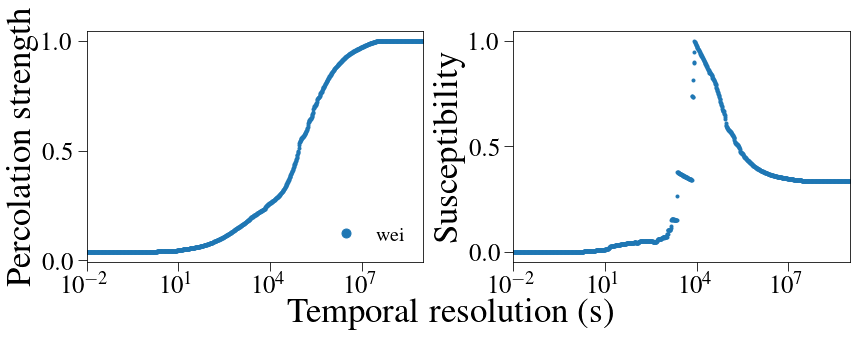

In [16]:
fig = plt.figure()
fig.set_size_inches(12,4)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
AX = [ax1, ax2]

##########################

CHI = (var - s**2) / s

indx = np.where(CHI == max(CHI[CHI>0]))[0][0]
print('%s: Max susceptibility is at %g seconds' %(dataset, x[indx]))

d = x[indx]

ax1.plot(x, s/max(s), 'o', markersize=3, label = dataset)
ax2.plot(x, CHI/max(CHI), 'o', markersize=3)

##########################

for ax in AX:
    ax.set_xlim(0.01, 10**9)
    ax.set_xscale('log')
    
ax1.legend(loc=4, markerscale=3)


ax1.set_ylabel('Percolation strength')
ax2.set_ylabel('Susceptibility')
labx = fig.text(0.525, -0.05, 'Temporal resolution (s)', fontsize=35, ha='center')


plt.tight_layout()
plt.show()

In [17]:
delta = float('%g' %d)
print('The optimal resolution is:', delta)

The optimal resolution is: 8413.92


### Avalanches distribution and exponents

In [18]:
start = datetime.now()

path = './avalanches/'

subprocess.Popen(['python3', 'avalanches.py', dataset, str(delta)], cwd=path).wait()

end = datetime.now()
print('Time required:', end-start)

Time required: 0:00:53.306416


In [19]:
f = path + 'res/' + dataset + '_delta' + str(delta) + '_avalanches.npy'

aval = np.load(f, allow_pickle=1)[()]

Error on tau: 0.0010778637979410436
Error on alpha: 0.004777045982526716
Error on hyperscaling relation: 0.0037890920780536148
Error on gamma: 0.04901653336489244


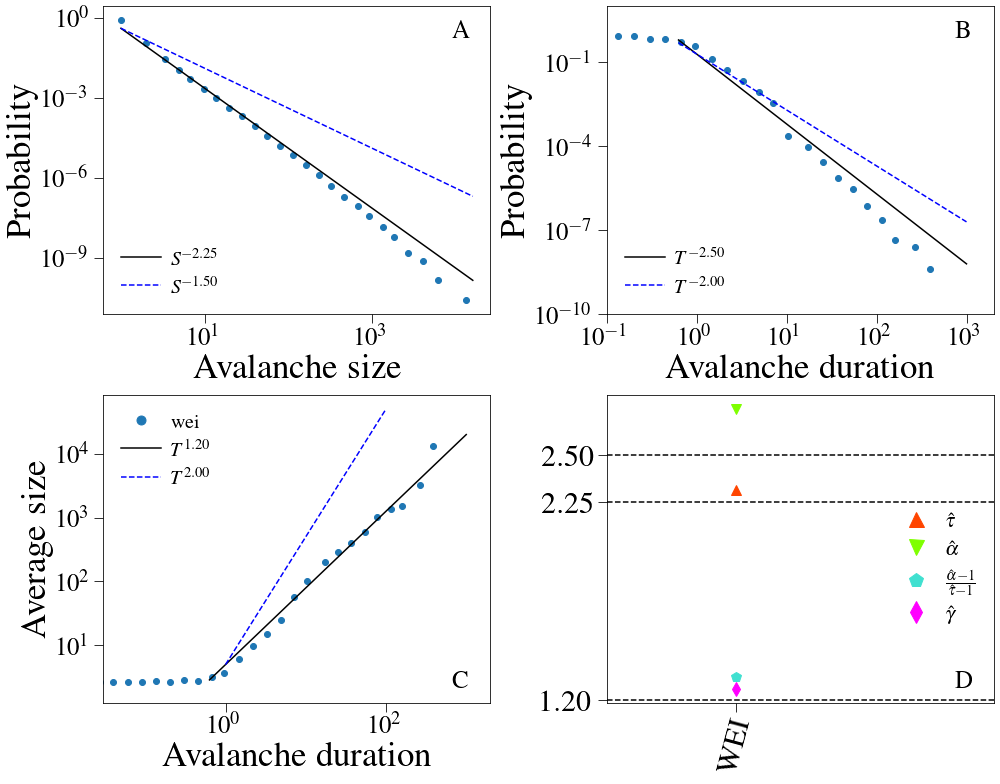

In [20]:
fig = plt.figure()
fig.set_size_inches(14, 11)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
AX = [ax1, ax2, ax3]


##########################


x, y = aval['popPDF']
ax1.plot(x, y, 'o', markersize=6)

x, y = aval['lifePDF']
ax2.plot(x/delta, y*delta, 'o', markersize=6)

x, y = aval['scaling']
ax3.plot(x/delta, y, 'o', markersize=6, label=dataset)

##########################

X = np.logspace(0, 4.2)
ax1.plot(X, 0.4*X**(-2.25), c='k', label='$S^{-2.25}$')
ax1.plot(X, 0.4*X**(-1.5), c='b', linestyle='--', label='$S^{-1.50}$')

X = np.logspace(-0.2, 3.)
ax2.plot(X, 0.2*X**(-2.5), c='k', label='$T^{-2.50}$')
ax2.plot(X, 0.2*X**(-2), c='b', linestyle='--', label='$T^{-2.00}$')

ax3.plot(X, 5*X**(1.2), c='k', label='$T^{1.20}$')
X = np.logspace(0, 2.0)
ax3.plot(X, 5*X**(2), c='b', linestyle='--', label='$T^{2.00}$')

##########################

x = 0.1
tau = aval['sizeMLE'][0]
alpha = aval['durationMLE'][0]
gamma = aval['linear_regression'][0]

print('Error on tau:', aval['sizeMLE'][1])
print('Error on alpha:', aval['durationMLE'][1])
print('Error on hyperscaling relation:', scaling_error(aval))
print('Error on gamma:', aval['linear_regression'][2])


marks = ['^', 'v', 'p', 'd']
c = ['orangered', 'chartreuse', 'turquoise', 'fuchsia']

ax4.plot(x, tau, marker=marks[0], color=c[0], markersize=10, linewidth=0, label='$\\hat{\\tau}$')
ax4.plot(x, alpha, marker=marks[1], color=c[1], markersize=10, linewidth=0, label = '$\\hat{\\alpha}$')
ax4.plot(x, (alpha-1)/(tau-1), marker=marks[2], color=c[2], linewidth=0, markersize=10,\
         label = '$\\frac{\hat{\\alpha}-1}{\hat{\\tau}-1}$')
ax4.plot(x, gamma, marker=marks[3], color=c[3], markersize=10, linewidth=0, label = '$\hat{\\gamma}$')


ax4.axhline(2.25, color='k', linestyle='--')
ax4.axhline(2.5, color='k', linestyle='--')
ax4.axhline(1.2, color='k', linestyle='--')


##########################


ax1.set_xlabel('Avalanche size')
ax2.set_xlabel('Avalanche duration')
ax3.set_xlabel('Avalanche duration')

ax1.set_ylabel('Probability')
ax2.set_ylabel('Probability')
ax3.set_ylabel('Average size')


ax4.set_xticks([0.1])
ax4.set_xticklabels(['WEI'], fontsize=30, rotation = 75)

ax4.set_yticks([1.2, 2.25, 2.5])
ax4.set_yticklabels(['$1.20$', '$2.25$', '$2.50$'], fontsize=30)#, rotation = 50)


ax2.set_xlim(0.1, 2*10**3)
ax2.set_ylim(10**(-10), 10)
ax3.set_xlim(0.3*0.1, 2*10**3)
ax4.set_xlim((-0.1, 0.5))

for ax in AX:
    ax.set_xscale('log')
    ax.set_yscale('log')
    

ax1.text(0.9, 0.9, 'A', transform=ax1.transAxes, fontsize=25)
ax2.text(0.9, 0.9, 'B', transform=ax2.transAxes, fontsize=25)
ax3.text(0.9, 0.05, 'C', transform=ax3.transAxes, fontsize=25)
ax4.text(0.9, 0.05, 'D', transform=ax4.transAxes, fontsize=25)

ax1.legend(loc=3)
ax2.legend(loc=3)
ax3.legend(loc=2)
ax4.legend(loc='lower right', bbox_to_anchor=(1,0.2))


plt.tight_layout()
plt.show()

# 3: Statistical analysis of individual time series 

Fitting numerous time series to dynamical models can be costly in terms of execution time so we divided the computation across different cores. The number of cores used is set by the variable `NumCores`. Small `NumCores` means a longer execution time. In order to efficiently exploit the parallelization, we create several input files in which the time series are already coarse grained in avalanches. Time series are stored so that larger time series are in the first files. The first files, however, contain only few time series. In this way, fitting the first files means fitting few - but the biggest - time series and, vice versa, fitting the last files mean fitting many - but the smallest -  time series. As stated in the SM of [1], we do not fit time series with less than 10 avalanches or with less than 50 events. 

Once files are created, the fitting procedure is performed by a separate code which can be found in the folder `data_vs_models`. The folder contains the code, its associated README, a makefile to create the executable, a folder, `res`, where the results of the analysis are stored and a folder, `inp`, where input files are stored.
This notebook serves as an example to understand how to use the code. We run it using `NumCores` by means of the `python` code `paral_runs.py`. This code takes in input the name of the dataset, the temporal resolution used to construct avalanches, the value of $S_{min}$, the number of files to be studies and the number of cores to be used for the computation.

### Functions for section 3

In [21]:
# Read results of the fitting procedure
def load_classification_results(fbase, NumFiles):
    
    ZeroLikel = 0
    N, R, n, p1, p2, logratio = [], [], [], [], [], []
    for filenum in range(NumFiles):
        f = fbase + '_num%d.txt' %(filenum+1)
        
        with open(f) as F:
            for i, line in enumerate(F):
                
                l = line.split()

                if line.startswith('Both likelihoods are zero'):
                    ZeroLikel += 1
                    
                elif line.startswith('RFIM fitted, BP not fitted'):
                    N.append(float(l[-3]))
                    R.append(float(l[-2]))
                    n.append(-1)
                    p1.append(1)
                    p2.append(-1)
                    logratio.append(1)

                elif line.startswith('RFIM not fitted, BP fitted'):
                    N.append(float(l[-3]))
                    R.append(-1)
                    n.append(float(l[-2]))
                    p1.append(1)
                    p2.append(-1)
                    logratio.append(-1)
                    
                elif line.startswith('This time series can not be fitted'):
                    pass
#                     N.append(0)
#                     R.append(-1)
#                     n.append(-1)
#                     p1.append(-1)
#                     p2.append(-1)
#                     logratio.append(-1)
                else:
                    N.append(int(float(l[0])))
                    R.append(float(l[1]))
                    n.append(float(l[2]))
                    p1.append(float(l[5]))
                    p2.append(float(l[6]))
                    logratio.append(float(l[7]))
    
                
    
    res = np.array([N, R, n, p1, p2, logratio])
    
    return res, ZeroLikel
                        
    
    
# Histograms of best fitting parameters
def parameter_distributions(fits, Rs, Zs):
    
    N = fits[0, :]
    R = fits[1, :]
    n = fits[2, :]

    RFIMhist, BPhist = {}, {}

    RFIMhist['x'] = np.array(Rs + [0])
    RFIMhist['y1'] = np.zeros(len(RFIMhist['x']))
    RFIMhist['y2'] = np.zeros(len(RFIMhist['x']))

    BPhist['x'] = np.array(Zs + [0.005])
    BPhist['y1'] = np.zeros(len(BPhist['x']))
    BPhist['y2'] = np.zeros(len(BPhist['x']))

    Z1, Z2, Z3, Z4 = 0, 0, 0, 0
    for i in range(len(N)):

        r = R[i]
        enn = n[i]

        if r > 0:
            ind = np.where(RFIMhist['x'] == r)[0][0]
            RFIMhist['y1'][ind] += 1
            RFIMhist['y2'][ind] += N[i]

            Z1 += 1
            Z2 += N[i]

        if enn > 0:
            ind = np.where(BPhist['x'] == enn)[0][0]
            BPhist['y1'][ind] += 1
            BPhist['y2'][ind] += N[i]

            Z3 += 1
            Z4 += N[i]


    RFIMhist['y1'] /= Z1
    RFIMhist['y2'] /= Z2
    BPhist['y1'] /= Z3
    BPhist['y2'] /= Z4
    
    return RFIMhist, BPhist



# Results of classification task
def classification(fits, pmin):
    
    class1 = {'RFIM' : 0, 'BP' : 0, 'None' : 0, 'Both' : 0}
    class2 = {'RFIM' : 0, 'BP' : 0, 'Z' : 0}

    for i in range(len(fits[0, :])):

        p1, p2, logratio = fits[3, i], fits[4, i], fits[5, i]


        if p1 > pmin and p2 <= pmin:
            class1['RFIM'] += 1

        if p1 <= pmin and p2 > pmin:
            class1['BP'] += 1

        if p1 < pmin and p2 < pmin:
            class1['None'] += 1

        if p1 >= pmin and p2 >= pmin:
            class1['Both'] += 1
            class2['Z'] += 1

            if logratio >= 0:
                class1['RFIM'] += 1
                class2['RFIM'] += 1
            else:
                class1['BP'] += 1
                class2['BP'] += 1


    Z = 0
    for k in ['RFIM', 'BP', 'None']:
        Z += class1[k]

    for k in class1:
        class1[k] /= Z
        
    return class1, class2

### Data preparation

In [22]:
### Each TS is coarse-grained into a sequence avalanches' size.

inp = {}
hashtags, TSsizes = [], []

for k in TS:
    ts = TS[k]
    
    s = 1
    S = []

    for dt in ts[1:-1]:
        if dt > delta:
            S.append(s)
            s = 0
        s += 1

    S.append(s)
    N = sum(S)

    if len(S) >= 10 and N >= 50:

        hashtags.append(k)
        TSsizes.append(N)

        Nav = len(S)
        inp[k] = [N, Nav]
        for s in S:
            inp[k].append(s)


In [23]:
### Sort hashtags from the one with less events to the one with more events

L = list(zip(*sorted(zip(TSsizes,hashtags))))
N = L[0]
hashtags = L[1]

hashtags = list(reversed(hashtags))

In [24]:
### Create input files 

path = './data_vs_models/inp/'
filebase = dataset + '_delta' + str(delta) + '_model_selection_input'
f2 = dataset + '_delta' + str(delta) + '_hashtags_to_line_map.txt'


tot = 0
num = len(N)
edges = np.logspace(1, 7)
rows = np.cumsum(edges).astype(int)          # Number of rows of each file


F2 = open(path+f2,'w')
for filenum in range(len(rows)):
    r = rows[filenum]
    
    curr = 0                                 # Number of raws of current file
    f1 = filebase + '_num' + str(filenum+1) + '.txt'
    F1 = open(path+f1, 'w')

    
    while(tot < num):
        k = hashtags[tot]
        
        F2.write(str(k) + ' ' + str(N[tot]) + '\n')
        
        
        for val in inp[k]:
            F1.write(str(int(val)) + ' ')
        F1.write('\n')

        curr += 1
        tot += 1
        if curr == r:                        # Current file is filled. Next file begins
            break
            
    F1.close()
    
    print('In file %d I put %d time series.' %(filenum+1, curr))
    
    if tot == num:                           # All data have been stored
        break

print(tot == num)

In file 1 I put 10 time series.
In file 2 I put 23 time series.
In file 3 I put 40 time series.
In file 4 I put 64 time series.
In file 5 I put 95 time series.
In file 6 I put 135 time series.
In file 7 I put 190 time series.
In file 8 I put 262 time series.
In file 9 I put 357 time series.
In file 10 I put 484 time series.
In file 11 I put 651 time series.
In file 12 I put 874 time series.
In file 13 I put 1168 time series.
In file 14 I put 1559 time series.
In file 15 I put 2077 time series.
In file 16 I put 2764 time series.
In file 17 I put 3674 time series.
In file 18 I put 4881 time series.
In file 19 I put 6481 time series.
In file 20 I put 8601 time series.
In file 21 I put 8749 time series.
True


### Fitting

In [25]:
### Time series fitting

# dataset = 'wei'
# delta = 8413.92

Smin = 10
NumFiles = filenum+1
NumCores = 10             # Set this opportunely!


start = datetime.now()

path = './data_vs_models/code/'
subprocess.Popen(['make'], cwd=path).wait()

subprocess.Popen(['python3', 'paral_runs.py', dataset, str(delta), str(Smin), str(NumFiles), str(NumCores)],\
                 cwd=path).wait()

end = datetime.now()
print('Time required:', end-start)

Time required: 1:30:07.058915


### Results

In [26]:
### Parameter space

R = 2.70
Rs = []

while (R > 0.001):
    Rs.append(float(str(R)[:5]))
    R -= 0.025


z = 1.70
Zs = []

while (z > 0.01):
    Zs.append(float(str(z)[:5]))
    z -= 0.015


In [27]:
### Load results

path = './data_vs_models/res/'
fbase = path + '%s_fit_Smin%g_delta%g' %(dataset, Smin, delta)

fits, ZeroLikel = load_classification_results(fbase, NumFiles)

print('Time series with zero likelihood for both models:', ZeroLikel/len(TS))

Time series with zero likelihood for both models: 0.0


In [28]:
### Analysis

RFIMhist, BPhist = parameter_distributions(fits, Rs, Zs)

pmin = 0.1
class1, class2 = classification(fits, pmin)

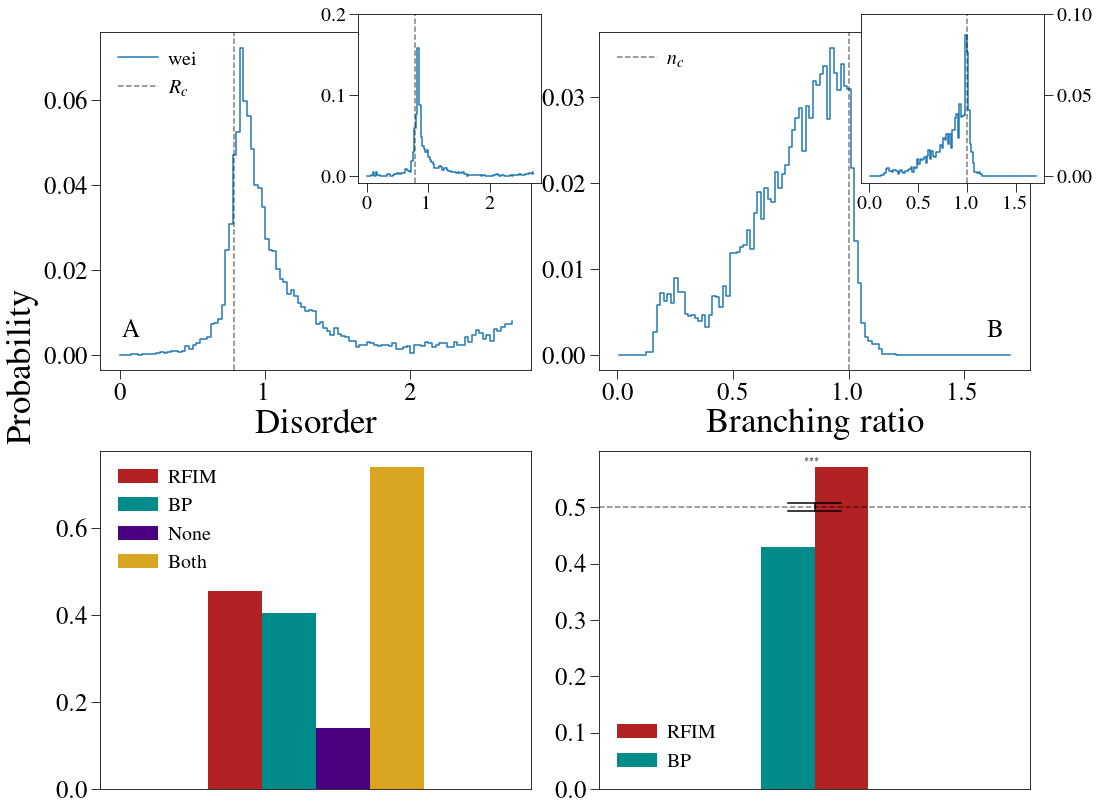

In [29]:
fig = plt.figure()
fig.set_size_inches(14, 11)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

AX = [ax1, ax2, ax3, ax4]

ax1_inset = inset_axes(ax1, width="100%", height="100%",
                    bbox_to_anchor=(.575, .525, .425, .5),
                    loc = 'lower left',
                    bbox_transform=ax1.transAxes)

ax2_inset = inset_axes(ax2, width="100%", height="100%",
                    bbox_to_anchor=(.585, .525, .425, .5),
                    loc = 'lower left',
                    bbox_transform=ax2.transAxes)



###############################
###############################


x, y = RFIMhist['x'], RFIMhist['y1']
ax1.step(x, y, label=dataset)
x, y = RFIMhist['x'], RFIMhist['y2']
ax1_inset.step(x, y)


x, y = BPhist['x'], BPhist['y1']
ax2.step(x, y)
x, y = BPhist['x'], BPhist['y2']
ax2_inset.step(x, y)



y1, y2, y3, y4 = class1['RFIM'], class1['BP'], class1['None'], class1['Both']


x = 0.2
dx = 0.1
ax3.bar(x, y1, width=dx, align='edge', color='firebrick', label='RFIM')
ax3.bar(x+dx, y2, width=dx, align='edge', color='darkcyan', label='BP')
ax3.bar(x+2*dx, y3, width=dx, align='edge', color='indigo', label='None')
ax3.bar(x+3*dx, y4, width=dx, align='edge', color='goldenrod', label='Both')



y1, y2, Z = class2['RFIM'], class2['BP'], class2['Z']
ax4.bar(x, y1/Z, width=0.05, align='edge', color='firebrick', label='RFIM')
ax4.bar(x, y2/Z, width=-0.05, align='edge', color='darkcyan', label='BP')


p = 1/2
sig = np.sqrt(p*(1-p)*Z)/Z

ax4.plot([x,x], [0.5+sig, 0.5-sig], c='k')
ax4.plot([x-0.05/2,x+0.05/2], [0.5+sig, 0.5+sig], c='k')
ax4.plot([x-0.05/2,x+0.05/2], [0.5-sig, 0.5-sig], c='k')

G = (y1 - Z*p) / np.sqrt(Z*p*(1-p))
pval = stats.norm.cdf(-np.abs(G))

if pval < 0.001:
    text = '***'
elif pval < 0.01 and p > 0.001:
    text = '**'
elif pval < 0.1 and p > 0.01:
    text = '*'
else:
    text = ''

ax4.text(x-0.01, max([y1/Z, y2/Z])+0.005, text, color='k', fontsize=10)


###############################
###############################

ax4.axhline(0.5, c='k', linestyle='--', alpha=0.5)


ax1.set_xlabel('Disorder')
ax2.set_xlabel('Branching ratio')
fig.text(-0.01, 0.475, 'Probability', fontsize=35, rotation='vertical', ha='center')


ax1_inset.set_xticks([0,1,2])
ax1_inset.set_xticklabels([0,1,2], fontsize=20)#, ha='left')

ax1_inset.set_yticks([0,.1,.2])
ax1_inset.set_yticklabels([0.0,0.1,0.2], fontsize=20)

ax2_inset.set_xticks([0,0.5,1,1.5])
ax2_inset.set_xticklabels([0.0,0.5,1.0,1.5], fontsize=20)#, ha='left')

ax2_inset.set_yticks([0,.05, 0.1])
ax2_inset.set_yticklabels(['0.00','0.05','0.10'], fontsize=20)

ax2_inset.yaxis.set_ticks_position('right')

ax3.set_xticks([])
ax4.set_xticks([])


ax3.set_xlim(0, 0.8)
ax4.set_xlim(0, 0.4)

ax1.axvline(0.7879, c='k', linestyle='--', alpha=0.5, label='$R_c$')
ax1_inset.axvline(0.7879, c='k', linestyle='--', alpha=0.5, label='$R_c$')
ax2.axvline(1, c='k', linestyle='--', alpha=0.5, label='$n_c$')
ax2_inset.axvline(1, c='k', linestyle='--', alpha=0.5, label='$n_c$')


ax1.text(0.05, 0.1, 'A', transform=ax1.transAxes, fontsize=25)
ax2.text(0.9, 0.1, 'B', transform=ax2.transAxes, fontsize=25)

ax1.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)
ax4.legend(loc=3)


plt.tight_layout()
plt.show()